# Real or Not? NLP with Disaster Tweets - Analysis and Predictions with Neural Network
## Methodology inspired by [this article](https://medium.com/real-or-not-nlp-with-disaster-tweets/real-or-not-nlp-with-disaster-tweets-a-data-science-capstone-project-fafa6c35c16f) on Medium and [this](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove) Kaggle kernel. Model history plotting functions from [this repo](https://github.com/CrazyHooch1/DisasterTweetsNLP). GloVe embeddings provided by [this](https://www.kaggle.com/jdpaletto/glove-global-vectors-for-word-representation) kernel.

In [1]:
#Data manipulation and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Text processing and cleaning
import re
from tqdm import tqdm

#Data generation
from sklearn.model_selection import train_test_split

#Model structure
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

#Model tuning
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

#Model accuracy
from sklearn.metrics import accuracy_score

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

# 1. Exploratory Data Analysis

In [3]:
X_full = pd.read_csv('train.csv')
print(X_full)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

## Missing values need to be filled in properly. Because the location feature itself is not standardized/automatically generated, we should drop it!

In [4]:
X_full = X_full.drop(['location'], axis=1)

## We can check if different properties of the text itself can be good predictors.

### a) Tweet length

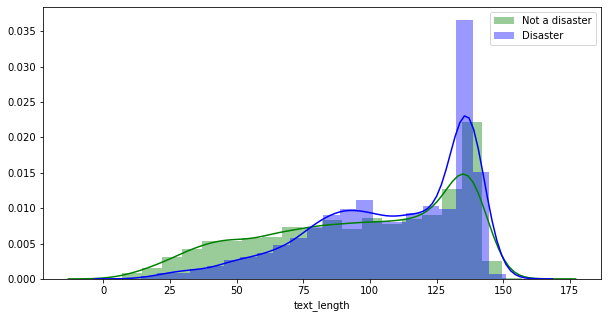

In [5]:
X_full['text_length'] = X_full['text'].apply(lambda x : len(x))
plt.figure(figsize=(10, 5))
sns.distplot(X_full[X_full['target'] == 0]['text_length'], color='green', label='Not a disaster')
sns.distplot(X_full[X_full['target'] == 1]['text_length'], color='blue', label='Disaster')
plt.legend()

### Evidently, there doesn't seem to be a discernable correlation between the tweets: both disasterous and non-disasterous tweets have long and short text lengths.

### b) Number of words in the tweet

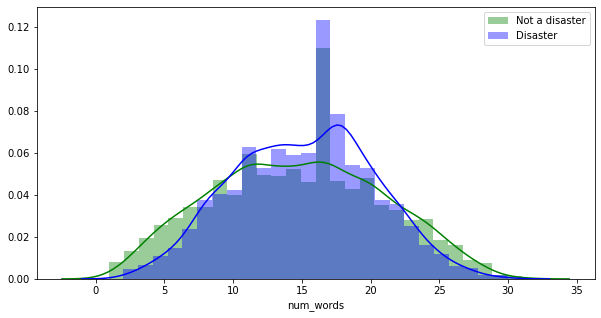

In [6]:
X_full['num_words'] = X_full['text'].apply(lambda x : len(x.split()))
plt.figure(figsize=(10, 5))
sns.distplot(X_full[X_full['target'] == 0]['num_words'], color='green', label='Not a disaster')
sns.distplot(X_full[X_full['target'] == 1]['num_words'], color='blue', label='Disaster')
plt.legend()

### These distributions appear to be similar, indicating little to know predictive power.

### c) Average word length in the tweet

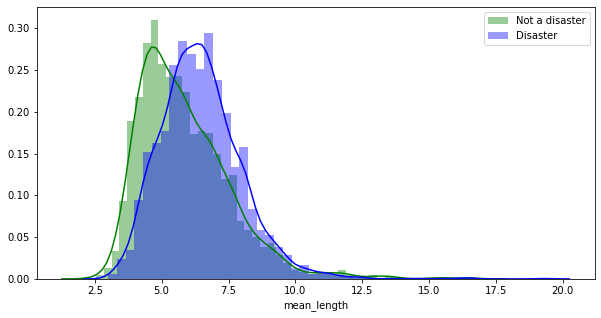

In [7]:
X_full['mean_length'] = X_full['text'].apply(lambda x : np.mean([len(w) for w in x.split()]))
plt.figure(figsize=(10, 5))
sns.distplot(X_full[X_full['target'] == 0]['mean_length'], color='green', label='Not a disaster')
sns.distplot(X_full[X_full['target'] == 1]['mean_length'], color='blue', label='Disaster')
plt.legend()

### There appears to be a slight difference in the distributions, but not enough to warrant keeping mean word length in a tweet as a predictor.

# 2. Data Preprocessing
## Data preprocessing for NLP consists of cleaning and tokenizing the text. We make sure all text is lowercase so the algo treats all text equally and precomputed embeddings can be used.
#### A) Remove URLs present in the tweets
#### B) Remove noise (punctuation, special characters, etc.)
#### C) Remove emojis

In [8]:
def url_removal(data: pd.DataFrame) -> pd.DataFrame:
    print('URL Removal started')
    for i in tqdm(range(data.shape[0])):
        if 'http' in data['text'][i]:
            new_text = remove_url(data['text'][i])
            data['text'][i] = new_text
    return data

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [9]:
def noise_removal(data: pd.DataFrame) -> pd.DataFrame:
    print('Noise Removal started')
    data['text'] = data['text'].str.lower()
    #Getting all alphanumeric characters
    alphanumeric = []
    for value in range(0, 128):
        if (value >= 48 and value <= 57) or (value >= 97 and value <= 122) or value == 32:
            alphanumeric.append(chr(value))
    for i in tqdm(range(data.shape[0])):
        current_string = list(data['text'][i])
        new_string = []
        for j in range(len(current_string)):
            if current_string[j] in alphanumeric:
                new_string.append(current_string[j])
        new_string = ''.join(new_string)
        data['text'][i] = new_string
    return data

In [10]:
def emoji_removal(data: pd.DataFrame) -> pd.DataFrame:
    print('emoji removal started')
    for i in tqdm(range(data.shape[0])):
        new_text = remove_emoji(data['text'][i])
        data['text'][i] = new_text
    return data

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [11]:
def preprocessor(data: pd.DataFrame) -> pd.DataFrame:
    data = url_removal(data)
    data = noise_removal(data)
    data = emoji_removal(data)
    return data

In [12]:
X_full = preprocessor(X_full)

#Separate the target variable from the corpus
y = X_full['target']

  5%|███▉                                                                         | 387/7613 [00:00<00:01, 3834.89it/s]

URL Removal started


  2%|█▊                                                                           | 184/7613 [00:00<00:04, 1838.59it/s]

Noise Removal started


  4%|██▊                                                                          | 278/7613 [00:00<00:02, 2567.99it/s]

emoji removal started


100%|████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:02<00:00, 3424.24it/s]


In [13]:
print(X_full)

         id keyword                                               text  \
0         1     NaN  our deeds are the reason of this earthquake ma...   
1         4     NaN              forest fire near la ronge sask canada   
2         5     NaN  all residents asked to shelter in place are be...   
3         6     NaN  13000 people receive wildfires evacuation orde...   
4         7     NaN  just got sent this photo from ruby alaska as s...   
...     ...     ...                                                ...   
7608  10869     NaN  two giant cranes holding a bridge collapse int...   
7609  10870     NaN  ariaahrary thetawniest the out of control wild...   
7610  10871     NaN              m194 0104 utc5km s of volcano hawaii    
7611  10872     NaN  police investigating after an ebike collided w...   
7612  10873     NaN  the latest more homes razed by northern califo...   

      target  text_length  num_words  mean_length  
0          1           69         13     4.384615  
1      

## We split the model into training and validation data.

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_full['text'], y, test_size=0.20, random_state=10)

## Tokenizing and padding the data such that it can be comprehensible by the model.

In [15]:
MAX_LEN = 100

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_valid_tokenized = tokenizer.texts_to_sequences(X_valid)

X_train_padded = pad_sequences(X_train_tokenized,
                              padding='post', 
                              truncating='post',
                              maxlen=MAX_LEN)
X_valid_padded = pad_sequences(X_valid_tokenized,
                              padding='post', 
                              truncating='post',
                              maxlen=MAX_LEN)

## Vectorizing the target

In [16]:
y_train = y_train.values
y_valid = y_valid.values

## Creating word embeddings matrix (GloVe) from precomputed embeddings.

In [17]:
embedding_dict={}
with open('./glove.twitter.27B.100d.txt', 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        word_vector = np.array(values[1:], 'float32')
        embedding_dict[word] = word_vector
file.close()

In [18]:
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue

    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 3. Defining NN model for text classification (Baseline model)

In [19]:
def build_model(dropout_, 
                reg_val_,
                capacity_,
                activation_,
                learning_rate_):

    embedding_dim = 100

    model = Sequential()
    embedding = Embedding(input_dim=num_words,
                          output_dim=embedding_dim,
                          weights=[embedding_matrix],
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=MAX_LEN,
                          trainable=False)

    model.add(embedding)
    model.add(GlobalMaxPooling1D())
    model.add(Dense(capacity_, activation=activation_,
                   kernel_regularizer=regularizers.l2(reg_val_)))
    model.add(Dropout(dropout_))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate_)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()
    return model

In [20]:
model = build_model(0.5, 0.02, 64, 'relu', 1e-3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1557900   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,564,429
Trainable params: 6,529
Non-trainable params: 1,557,900
_________________________________________________________________


In [21]:
%%time

history = model.fit(X_train_padded, y_train,
                     validation_data=(X_valid_padded, y_valid),
                     epochs=300,
                     batch_size=1000,
                     verbose=0,
                     use_multiprocessing=True)

Wall time: 1min 37s


In [22]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'crimson', label='Training acc')
    plt.plot(x, val_acc, 'lightgreen', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'crimson', label='Training loss')
    plt.plot(x, val_loss, 'lightgreen', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

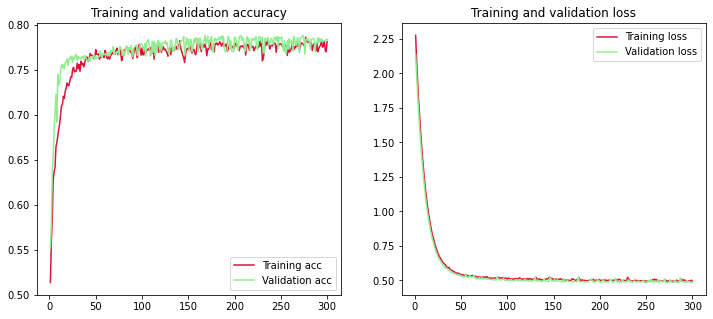

In [23]:
plot_history(history)

In [24]:
#Evaluating model accuracy
model.evaluate(X_valid_padded, y_valid)

48/48 [==============================] - 0s 3ms/step - loss: 0.4858 - accuracy: 0.7840


[0.48579832911491394, 0.7839789986610413]

# 4. Model Hyperparameter Tuning
## Current hyperparameters: Dropout, Regularization Constant, Dense Layer Capacity, Dense Layer Activation, Optimizer Learning Rate, Batch Size

In [25]:
params = dict(dropout_=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              reg_val_=[0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
              capacity_=[16, 32, 64, 128, 256, 512],
              activation_=['relu', 'tanh', 'selu'],
              learning_rate_=[1e-1, 1e-2, 1e-3])
print(params)

{'dropout_': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'reg_val_': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09], 'capacity_': [16, 32, 64, 128, 256, 512], 'activation_': ['relu', 'tanh', 'selu'], 'learning_rate_': [0.1, 0.01, 0.001]}


In [26]:
tune_model = KerasClassifier(build_fn=build_model, epochs=100, batch_size=4000, verbose=0)

In [27]:
np.random.seed(42)

In [28]:
%%capture
rscv = RandomizedSearchCV(tune_model, param_distributions=params, n_iter=5, verbose=0)
rscv_results = rscv.fit(X_train_padded, y_train)

In [29]:
print('Best score is: {} using {}'.format(rscv_results.best_score_, rscv_results.best_params_))

Best score is: 0.7678161025047302 using {'reg_val_': 0.0, 'learning_rate_': 0.001, 'dropout_': 0.8, 'capacity_': 64, 'activation_': 'relu'}


In [41]:
best_model = build_model(reg_val_=rscv_results.best_params_['reg_val_'], 
                         learning_rate_=rscv_results.best_params_['learning_rate_'], 
                         dropout_=rscv_results.best_params_['dropout_'], 
                         capacity_=rscv_results.best_params_['capacity_'], 
                         activation_=rscv_results.best_params_['activation_'])
best_model_hist = best_model.fit(X_train_padded, y_train,
               validation_data=(X_valid_padded, y_valid),
               epochs=500,
               batch_size=5000,
               verbose=0,
               use_multiprocessing=True)
best_model.save_weights('model_300epoch_full.h5')

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 100, 100)          1557900   
_________________________________________________________________
global_max_pooling1d_28 (Glo (None, 100)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 65        
Total params: 1,564,429
Trainable params: 6,529
Non-trainable params: 1,557,900
_________________________________________________________________


In [42]:
best_model.evaluate(X_train_padded, y_train, verbose=0)

[0.43429240584373474, 0.80213463306427]

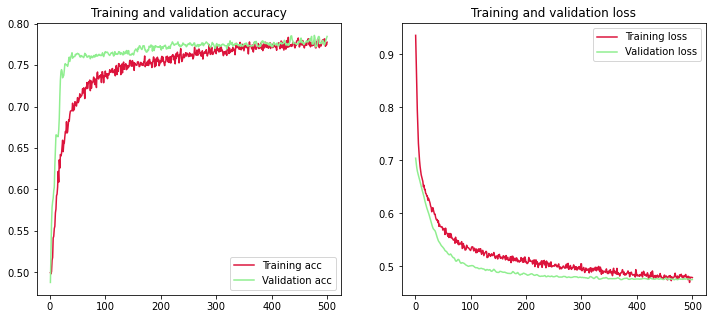

In [43]:
plot_history(best_model_hist)

# 5. Making predictions using the test set
## To make predictions using the test set, we have to load the data in, remove dirty features, clean it, and vectorize it. We use the best model to make predictions.

In [44]:
X_test_full = pd.read_csv('test.csv')
print(X_test_full)

         id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  
0                    Just happened a terrible car crash  
1     Heard about #earthquake is different cities, s...  
2     there is a forest fire at spot pond, geese are...  
3              Apocalypse lighting. #Spokane #wildfires  
4         Typhoon Soudelor kills 28 in China and Taiwan  
...                                                 ...  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  
3259  Storm in RI worse than last hurricane. My city...  
3260  Green Line derailment in Chicago http://t.co/U...  
3261  MEG issues Hazardous Weather 

In [45]:
# X_test_full = X_test_full.drop(['keyword', 'location'], axis=1)
X_test_full = preprocessor(X_test_full)
X_test = X_test_full['text']

 14%|██████████▉                                                                  | 462/3263 [00:00<00:00, 4022.04it/s]

URL Removal started


  7%|█████▋                                                                       | 239/3263 [00:00<00:01, 2083.72it/s]

Noise Removal started


 24%|██████████████████▊                                                          | 795/3263 [00:00<00:00, 3967.92it/s]

emoji removal started


100%|████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:00<00:00, 4288.56it/s]


In [46]:
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_tokenized, padding='post', maxlen=100)

In [47]:
#Making the prediction
test_preds = best_model.predict(X_test_padded)
preds = np.round(test_preds).astype(int).reshape(len(X_test_padded))

In [48]:
#Writing to submission file
submission = pd.DataFrame({
    'id':X_test_full['id'],
    'target':preds
})
submission.to_csv('submission.csv', index=False)